In [1]:
try:
     from dlroms import*
except:
     !pip install --no-deps git+https://github.com/NicolaRFranco/dlroms.git
     from dlroms import*

import numpy as np

## **Fisher-KPP equation**: damage propagation in a U-bolt

In [2]:
# FOM discretization
import gdown
gdown.download(id = "1_4uC_yjWmvaDfAuRt0I1PI3IENE4XYXX", output = "ubolt_mesh.xml")
mesh = fe.loadmesh("ubolt_mesh.xml")
Vh = fe.space(mesh, 'CG', 1)
clc()

In [3]:
# Dataset (parameters and FKPP simulations)
gdown.download(id = "1ehojde4rL-8-zoyiKikes3e76CpPvJzC", output = "ubolt.npz")
clc()
dataset = np.load("ubolt.npz")
mu, u = dataset['mu'], dataset['u']

In [4]:
# Fancy colormap for plotting
from matplotlib.colors import ListedColormap
import matplotlib as mpl
jet = mpl.colormaps['jet']
jet_colors = jet(np.linspace(0, 1, 256))
def modify_jet_to_gray(jet_colors):
    new_colors = jet_colors.copy()
    gray_vals = np.linspace(0.3, 0.7, 85)
    for i in range(85):
        new_colors[i, 0:3] = gray_vals[i]
    return ListedColormap(new_colors)
gray_jet = modify_jet_to_gray(jet_colors)

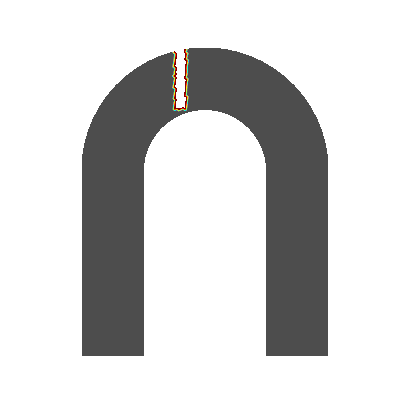

In [5]:
# First simulation in the dataset
fe.animate(u[0], Vh, cmap = gray_jet)

In [6]:
from dlroms.minns import Integral
u = dv.tensor(u).cpu()
ns, nt, nh = u.shape

space_integral = Integral(Vh)
clc()

def J(u):
  return space_integral(u).reshape(-1, nt).mean(axis = -1)

J(u).shape # Values of the functional J (see task (iii) - (iv)) across the dataset

J(u[:3]) # Values of the functional J on the first, second and third simulation

tensor([1.5723, 1.2846, 0.3781])

In [7]:
mu.shape,u.shape

((100, 3), torch.Size([100, 41, 6636]))

In [8]:
mu,u=dv.tensor(dataset['mu']),dv.tensor(dataset['u'])
display(mu.shape,u.shape)
ndata,ntimes,nh=u.shape
p=mu.shape[-1]
print("Trajectories:\t%d."% ndata)
print("Timesteps:\t%d."%ntimes)
print("FOM dimension:\t%d."%nh)
print("Parameters:\t%d."%p)

mut=dv.zeros(ndata,ntimes,p+1) #p+1 perche abbiamo la parametrizzazione + il tempo
times=dv.tensor(np.linspace(0,1,ntimes))
for i in range(ndata):
  mut[i,:,:3]=mu[i]
  mut[i,:,-1]=times

print(mut.shape) #tensore che contiene ndata x ntimes x (p+1)

torch.Size([100, 3])

torch.Size([100, 41, 6636])

Trajectories:	100.
Timesteps:	41.
FOM dimension:	6636.
Parameters:	3.
torch.Size([100, 41, 4])


In [9]:
u=u.reshape(-1,nh)
mut=mut.reshape(-1,p+1)
print(u.shape,mut.shape)

torch.Size([4100, 6636]) torch.Size([4100, 4])


In [10]:
l2=L2(Vh)
l2.cuda()
clc()
ntrain=75*ntimes #75 simulazioni per il train-set
ntest=25*ntimes  #25 simulazioni per il test-set
def error(utrue,upred):
  return ((l2(utrue-upred).reshape(-1,ntimes).sum(axis=-1))/l2(utrue).reshape(-1,ntimes).sum(axis=-1)).mean()

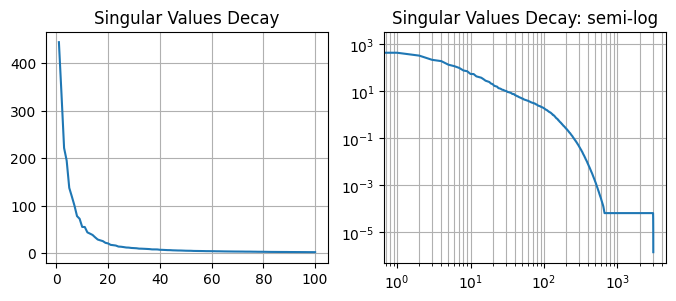

In [26]:
from scipy.linalg import svd
import matplotlib.pyplot as plt
%matplotlib inline

X,s,_=svd(u[:ntrain].T.cpu().numpy(),full_matrices=False)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(1+np.arange(100),s[1:101])
plt.grid()
plt.title("Singular Values Decay")
plt.subplot(1,2,2)
plt.title("Singular Values Decay: semi-log")
plt.loglog(s)
plt.grid(True,which='both')
plt.show()

In [12]:
from torch.optim import Adam
rho_e=lambda x:relu(x) -10*relu(-x)
rho_d= lambda x:relu(x) -0.1*relu(-x)

Latent=9
encoder=Dense(nh,50,rho_e)+Dense(50,Latent,rho_e)
decoder=Dense(Latent,50,rho_d)+Dense(50,100,rho_d)+Dense(100,nh,activation=None)
autoencoder=DFNN(encoder+decoder)

autoencoder.He()
autoencoder.cuda()

autoencoder.train(u,u,ntrain=ntrain,  epochs=30, loss=mse(l2),
                  error=error,notation='%')

autoencoder.train(u,u,ntrain=ntrain, epochs=2000, loss=mse(l2),
                  optim=Adam, lr=1e-5, batchsize=64,
                  error=error, notation='%')




		Train	Test
Epoch 2000:	3.85%	4.66%.

>> ETA: 0.35s.

Training complete. Elapsed time: 11 minutes 49.74 seconds.


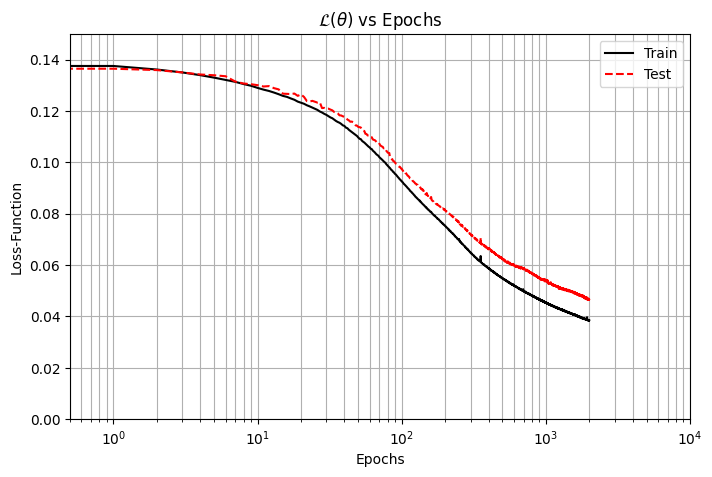

In [27]:

plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}(\theta)$ vs Epochs')
plt.semilogx(autoencoder.errors['Train'], '-k', label = 'Train')
#plt.semilogx(autoencoder.errors['Validation'], 'b', label = 'Validation')
plt.semilogx(autoencoder.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 1e+4, 0, 0.15])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [14]:
autoencoder.freeze()

In [15]:
print("Autoencoder MRE: %s"%num2p(error(u[ntrain:],autoencoder(u[ntrain:]))))

Autoencoder MRE: 4.66%


In [25]:
nu=encoder(u)
from dlroms.dnns import Fourier
fmodes=10
phi=DFNN(Fourier(fmodes, which=[-1]) + Dense(p+1+2*fmodes, 500, gelu) + Dense(500, Latent, activation = None))

phi.He()
phi.cuda()
phi.train(mut,nu,ntrain=ntrain, epochs=150,loss=mse(euclidean))
phi.freeze()

		Train		Test
Epoch 150:	5.68e+01	2.01e+03.

>> ETA: 0.78s.

Training complete. Elapsed time: 1 minutes 57.36 seconds.


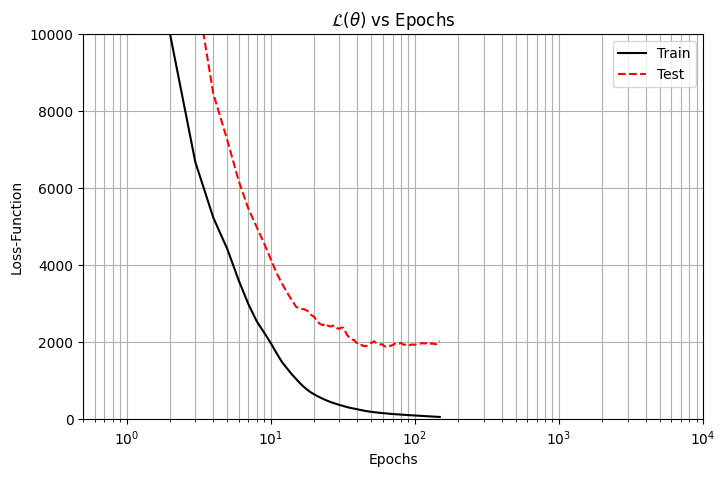

In [32]:
plt.figure(figsize = (8, 5))
plt.title(r'$\mathcal{L}(\theta)$ vs Epochs')
plt.semilogx(phi.errors['Train'], '-k', label = 'Train')
plt.semilogx(phi.errors['Test'], '--r', label = 'Test')
plt.xlabel('Epochs')
plt.ylabel('Loss-Function')
plt.axis([0.5, 1e+4, 0, 1e+4])
plt.grid(True,which="both", ls="-")
plt.legend()
plt.show()

In [ ]:
dlrom = lambda mt: decoder(phi(mt))
num2p(error(u[ntrain:], dlrom(mut[ntrain:])))

'9.32%'

In [33]:
def visualize(uexample):
    fe.animate(uexample[::2], Vh, figsize = (8, 2),colorbar=True)

#visualize(u[0])

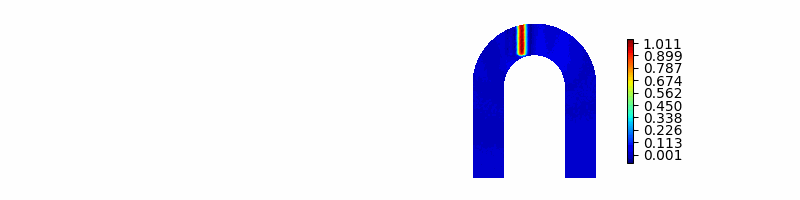

DL-ROM simulation time: 0.002s.


In [34]:
from time import perf_counter
mu0 = dv.tensor([5.8e-01, 7.2e-01, 6.1e-01])

mu0t = dv.zeros(ntimes, p+1)
mu0t[:, 3] = times
mu0t[:, :3] = mu0

t0 = perf_counter()
uROM = dlrom(mu0t)
t1 = perf_counter()
visualize(uROM)
print("DL-ROM simulation time: %.3fs." % (t1-t0))

In [35]:
print(uROM.shape)
uROM_III=uROM.cpu()
print(uROM_III.shape)
J(uROM_III)  #la funzione "J" prende dentro un torch.tensor() non np.array() !

torch.Size([41, 6636])
torch.Size([41, 6636])


tensor([1.6504])

In [36]:
print(mu[:,0].shape)
print(mut.reshape(100,41,-1).shape)
mut=mut.reshape(100,41,-1)

torch.Size([100])
torch.Size([100, 41, 4])


In [37]:
uROM_out=[]                       #list
mut_eval=dv.zeros(ndata,ntimes,4) #tensor
for i in range(ndata):            #ndata=100
    mut_eval=mut[i,:,:]           #variation of parameters per single simulation
    uROM=dlrom(mut_eval)          #evalutation of mut-tensor by means of the surrogate model! (performing 100 simulations in 0.4s)
    uROM_out.append(uROM.cpu().numpy())

uROM_val=np.stack(uROM_out)
print(uROM_val.shape)

(100, 41, 6636)


In [38]:
import torch
uROM_val=torch.from_numpy(uROM_val)
J(uROM_val)

tensor([1.5721, 1.2868, 0.3783, 1.5173, 1.5748, 1.6233, 0.8784, 1.1472, 4.5277,
        0.6086, 0.4256, 0.3368, 1.1150, 0.6634, 1.7600, 0.5044, 0.7606, 0.7898,
        1.0673, 1.1071, 2.7015, 0.4629, 0.6938, 2.9370, 2.3116, 1.5149, 0.8215,
        1.7919, 1.2126, 0.6708, 0.8181, 2.3766, 0.9336, 0.6766, 1.0531, 0.5737,
        1.4306, 1.1801, 1.9472, 1.9450, 0.3912, 0.3653, 2.5545, 0.7759, 0.5182,
        1.5555, 1.5776, 2.0644, 1.4159, 0.4927, 0.5039, 0.4111, 0.3890, 1.4352,
        0.6133, 1.9866, 0.9293, 0.4101, 0.7506, 0.6059, 0.4361, 0.6017, 0.6145,
        0.6826, 0.9541, 0.3222, 0.3748, 2.3032, 0.3596, 1.5265, 3.5672, 0.5833,
        0.9490, 1.1387, 1.3062, 0.4203, 1.5840, 1.9034, 0.8906, 0.8699, 1.4357,
        0.5991, 1.0116, 1.0968, 0.4458, 1.0401, 0.3740, 3.5232, 1.0686, 0.5370,
        0.3394, 0.4971, 2.6960, 1.4271, 1.4301, 0.4342, 1.8752, 4.0171, 1.3028,
        1.0458])

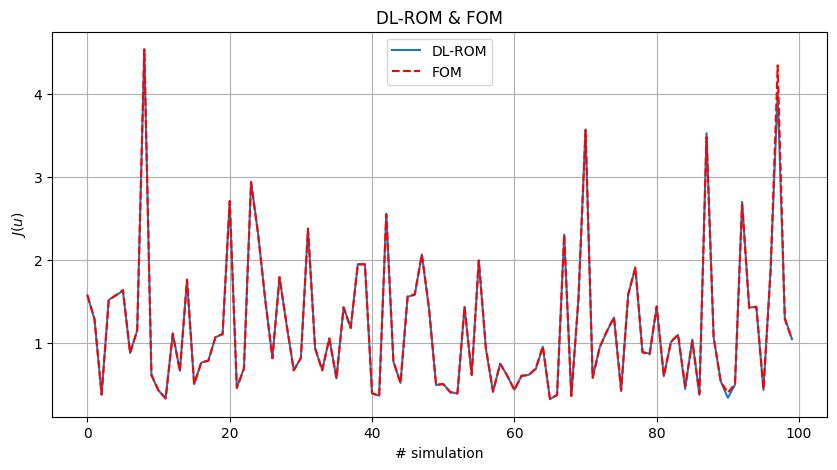

In [39]:
%matplotlib inline
plt.figure(figsize=(10,5))
plt.title("DL-ROM & FOM")
plt.plot(J(uROM_val),label="DL-ROM")
plt.plot(J(u.cpu()),color='r',ls='dashed',label="FOM")
plt.legend()
plt.ylabel(r'$J(u)$')
plt.xlabel('# simulation')
plt.grid()
plt.show()

Difference between the DL-ROM and the FOM in order to check the goodness of the approximation acchieved

In [40]:
diff=J(uROM_val)-J(u.cpu()) #difference

Text(0, 0.5, '$J(\\tilde{u})-J(u)$')

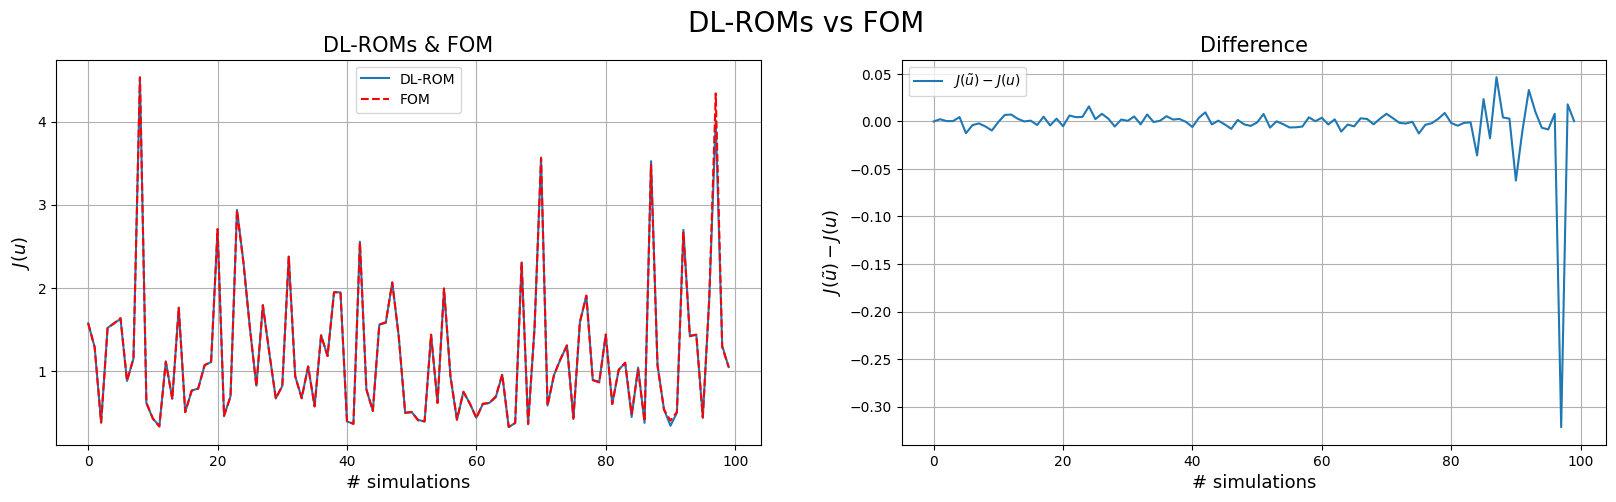

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))
fig.suptitle('DL-ROMs vs FOM',size="20")
ax1.set_title("DL-ROMs & FOM",size="15")
ax1.plot(J(uROM_val),label="DL-ROM")
ax1.plot(J(u.cpu()),color='r',ls='dashed',label="FOM")
ax1.grid()
ax1.set_xlabel("# simulations",size="13")
ax1.set_ylabel("$J(u)$",size="13")
ax1.legend()
ax2.set_title("Difference",size="15")
ax2.plot(diff,label=r"$J(\tilde{u})-J(u)$")
ax2.grid()
ax2.legend()
ax2.set_xlabel("# simulations",size="13")
ax2.set_ylabel(r"$J(\tilde{u})-J(u)$",size="13")

## SINDy
Utilizzare SINDy in questo caso può essere interessante per fittare la soluzione e trovare pertanto la funzione "analitica" dello stato finale del mio problema U-bolt, migliorare la dinamica del modello ora non è cosi importante in quanto ho gia un relative error del 5% quindi ampiamente sotto la soglia!

# To do
Sindy non sta considerando il parametro del tempo nel problema infatti quest'ultimo deve essere inserito in qualche modo nella componente $\texttt{mut}$